In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:

data_path = '/content/MergedData.csv'
data = pd.read_csv(data_path, encoding='ISO-8859-1')

In [ ]:
# convert times
def convert_to_seconds(t):
    if ':' in t:
        m, s = t.split(':')
        return int(m) * 60 + float(s)
    return float(t)

data['Time_in_seconds'] = data['Time'].apply(convert_to_seconds)

In [ ]:
# conevrt date
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y')

In [ ]:
# scaler
scaler_jason = MinMaxScaler(feature_range=(0, 1))
scaler_bryce = MinMaxScaler(feature_range=(0, 1))

In [ ]:
# filter data
jason_data = data[(data['Name'] == 'Jason Kim') & (data['Event'] == '100 FR SCY Male')].sort_values(by='Date', ascending=True)
bryce_data = data[(data['Name'] == 'Bryce Grover') & (data['Event'] == '100 FR SCY Male')].sort_values(by='Date', ascending=True)

jason_data['Time_in_seconds_scaled'] = scaler_jason.fit_transform(jason_data['Time_in_seconds'].values.reshape(-1, 1))
bryce_data['Time_in_seconds_scaled'] = scaler_bryce.fit_transform(bryce_data['Time_in_seconds'].values.reshape(-1, 1))

In [ ]:
sequence_length = 2

In [ ]:
def create_sequences(data, sequence_length):
    X, y = [], []
    if len(data) >= sequence_length:
        for i in range(len(data) - sequence_length):
            X.append(data['Time_in_seconds_scaled'].values[i:i+sequence_length])
            y.append(data['Time_in_seconds_scaled'].values[i+sequence_length])
    return np.array(X), np.array(y)

In [ ]:
# make jasons sequences
X_jason, y_jason = create_sequences(jason_data, sequence_length)
X_jason = X_jason.reshape(X_jason.shape[0], sequence_length, 1)

In [ ]:
# make bryces sequences
X_bryce, y_bryce = create_sequences(bryce_data, sequence_length)
X_bryce = X_bryce.reshape(X_bryce.shape[0], sequence_length, 1)

In [ ]:
# tts jason
X_train_jason, X_test_jason, y_train_jason, y_test_jason = train_test_split(X_jason, y_jason, test_size=0.1, random_state=123)

In [ ]:
# tts bryce
X_train_bryce, X_test_bryce, y_train_bryce, y_test_bryce = train_test_split(X_bryce, y_bryce, test_size=0.1, random_state=123)

In [ ]:
# function so model can be reused
def build_and_train_model(X_train, y_train):
    model = Sequential([
        LSTM(64, input_shape=(sequence_length, 1), activation='relu', return_sequences=False, kernel_regularizer=l2(0.1)),
        Dropout(0.5),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=300, validation_split=0.05, batch_size=16, callbacks=[early_stopping], verbose=0)

    return model, history

In [ ]:
# train for jason
model_jason, history_jason = build_and_train_model(X_train_jason, y_train_jason)

In [ ]:
# train for bryec
model_bryce, history_bryce = build_and_train_model(X_train_bryce, y_train_bryce)

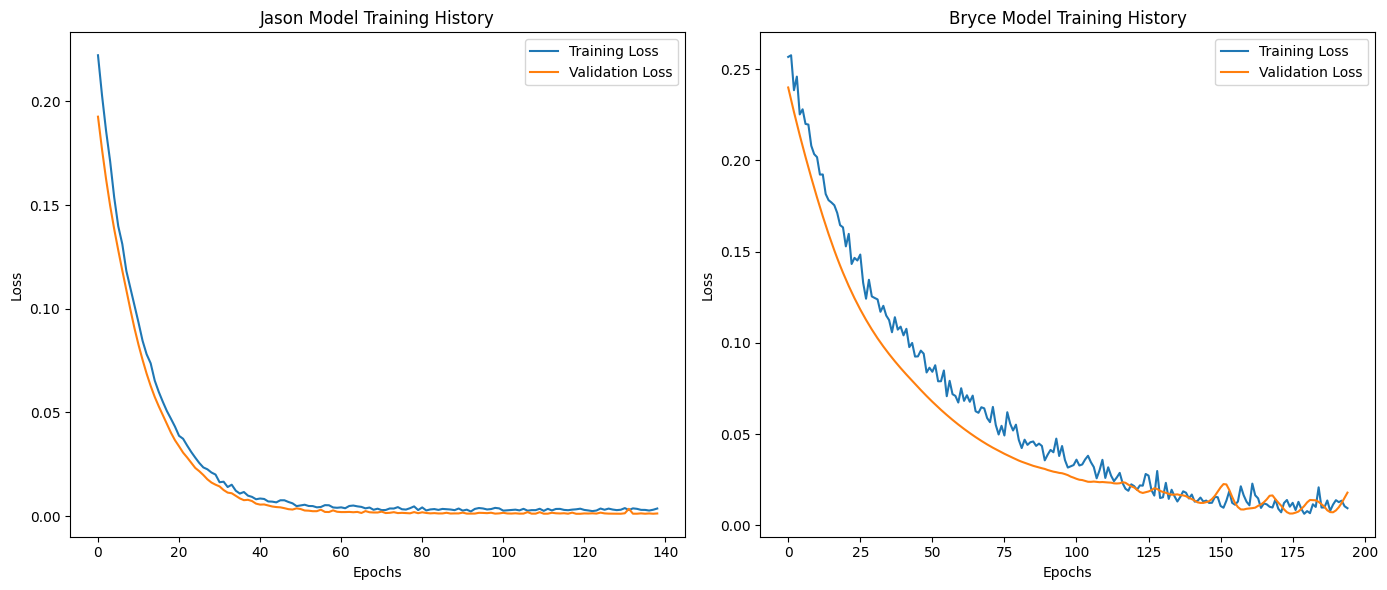

In [ ]:
# plot jason
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_jason.history['loss'], label='Training Loss')
plt.plot(history_jason.history['val_loss'], label='Validation Loss')
plt.title('Jason Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plot bryce
plt.subplot(1, 2, 2)
plt.plot(history_bryce.history['loss'], label='Training Loss')
plt.plot(history_bryce.history['val_loss'], label='Validation Loss')
plt.title('Bryce Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# jason
y_pred_jason = model_jason.predict(X_test_jason)
y_test_inverse_jason = scaler_jason.inverse_transform(y_test_jason.reshape(-1, 1))
y_pred_inverse_jason = scaler_jason.inverse_transform(y_pred_jason.reshape(-1, 1))

1/1 [==============================] - 0s 168ms/step


In [ ]:
# bryce
y_pred_bryce = model_bryce.predict(X_test_bryce)
y_test_inverse_bryce = scaler_bryce.inverse_transform(y_test_bryce.reshape(-1, 1))
y_pred_inverse_bryce = scaler_bryce.inverse_transform(y_pred_bryce.reshape(-1, 1))

1/1 [==============================] - 0s 139ms/step


In [ ]:
# jason mae rmse
mae_jason = mean_absolute_error(y_test_inverse_jason, y_pred_inverse_jason)
rmse_jason = np.sqrt(mean_squared_error(y_test_inverse_jason, y_pred_inverse_jason))

In [ ]:
# bryce mae rmse
mae_bryce = mean_absolute_error(y_test_inverse_bryce, y_pred_inverse_bryce)
rmse_bryce = np.sqrt(mean_squared_error(y_test_inverse_bryce, y_pred_inverse_bryce))

In [ ]:
print(f"Jason - MAE: {mae_jason}, RMSE: {rmse_jason}")

Jason - MAE: 0.8241513442993158, RMSE: 0.8907471051867883


In [ ]:
print(f"Bryce - MAE: {mae_bryce}, RMSE: {rmse_bryce}")

Bryce - MAE: 4.096458435058594, RMSE: 4.096458435058594


In [ ]:
# make forecasts
def make_forecasts(model, scaler, sequence_scaled, num_forecasts):
    forecasts = []
    current_sequence = sequence_scaled
    for _ in range(num_forecasts):
        next_pred = model.predict(current_sequence)
        forecasts.append(next_pred[0])
        next_pred_reshaped = np.reshape(next_pred, (1, 1, 1))  # Reshape the prediction to match the dimensions of current_sequence
        current_sequence = np.append(current_sequence[:, 1:, :], next_pred_reshaped, axis=1)
    return np.array(forecasts)

In [ ]:
# jason forecasts
jason_sequence_scaled = scaler_jason.transform(jason_data['Time_in_seconds'].values[-sequence_length:].reshape(-1, 1)).reshape(1, sequence_length, 1)
forecasts_jason_scaled = make_forecasts(model_jason, scaler_jason, jason_sequence_scaled, 10)
forecasts_jason = scaler_jason.inverse_transform(forecasts_jason_scaled.reshape(-1, 1))

1/1 [==============================] - 0s 18ms/step


In [ ]:
# bryce forecasts
bryce_sequence_scaled = scaler_bryce.transform(bryce_data['Time_in_seconds'].values[-sequence_length:].reshape(-1, 1)).reshape(1, sequence_length, 1)
forecasts_bryce_scaled = make_forecasts(model_bryce, scaler_bryce, bryce_sequence_scaled, 10)
forecasts_bryce = scaler_bryce.inverse_transform(forecasts_bryce_scaled.reshape(-1, 1))

1/1 [==============================] - 0s 18ms/step


In [ ]:
print("10 Forecasts for Jason:", forecasts_jason.flatten())

10 Forecasts for Jason: [49.659485 49.624058 49.650734 49.859467 50.09684  49.83782  49.84441
 49.864895 49.899475 49.912506]


In [ ]:
print("10 Forecasts for Bryce:", forecasts_bryce.flatten())

10 Forecasts for Bryce: [69.54131  69.37551  69.282166 69.24631  69.193695 69.14416  69.13147
 69.1243   69.11984  69.11553 ]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

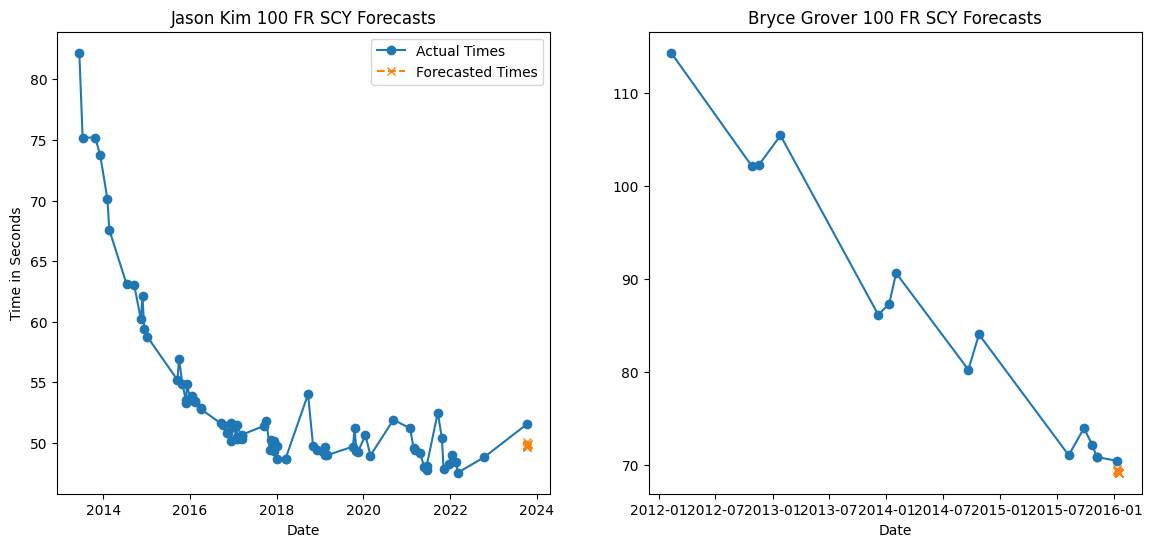

In [ ]:
# plot jason forecasts
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(jason_data['Date'], jason_data['Time_in_seconds'], marker='o', label='Actual Times')
forecast_dates_jason = pd.date_range(start=jason_data['Date'].values[-1], periods=10, freq='D')
plt.plot(forecast_dates_jason, forecasts_jason, marker='x', linestyle='--', label='Forecasted Times')
plt.title('Jason Kim 100 FR SCY Forecasts')
plt.xlabel('Date')
plt.ylabel('Time in Seconds')
plt.legend()

# plot bryce forecasts
plt.subplot(1, 2, 2)
plt.plot(bryce_data['Date'], bryce_data['Time_in_seconds'], marker='o', label='Actual Times')
forecast_dates_bryce = pd.date_range(start=bryce_data['Date'].values[-1], periods=10, freq='D')
plt.plot(forecast_dates_bryce, forecasts_bryce, marker='x', linestyle='--', label='Forecasted Times')
plt.title('Bryce Grover 100 FR SCY Forecasts')
plt.xlabel('Date')
plt